### Clustering analysis: 1 hour, single period

##### Hourly BTC chart

In [1]:
from algom.utils.data_object import dataObject
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import pandas as pd
import numpy as np


In [2]:
data = dataObject("""
select distinct
ticker_time,
ticker_time_sec,
ticker,
`interval` as ticker_interval,
volume_base,
volume,
open,
high,
low,
close,
round(log(safe_divide(high, open)), 5)  as open_high,
round(log(safe_divide(low, open)), 5)   as open_low,
round(log(safe_divide(close, open)), 5) as open_close,
ROR_n5,
ROR_n10,
ROR_n15,
ROR_n20,
from `algom-trading.cryptocompare.features_BTC_USD_hour_*`
where 
  _table_suffix in ('2018', '2019', '2020')
  and ROR_n20 is not null
order by ticker_time
""")

Downloading: 100%|██████████| 26037/26037 [00:06<00:00, 4074.68rows/s]


In [ ]:
data.df.tail()

<br><br>

### Calculate Elbow (ie inertia plot)

In [5]:
# Get features
feature_list = ['open_high', 'open_low', 'open_close']
X = data.df[feature_list]
cluster_summary = []

# Run kmeans
for n in range(2, 12, 1):
    print("RUNNING: Running cluster summary for k={}.".format(n))
    kmeans = KMeans(
        n_clusters=n,
        random_state=0,
    )
    kmeans = kmeans.fit(X)
    labels = kmeans.labels_
    silhouette = silhouette_score(X, labels)    
    cluster_summary.append({
        'n_clusters': kmeans.n_clusters,
        'inertia': kmeans.inertia_,
        'silhouette': silhouette,
    })


RUNNING: Running cluster summary for k=2.
RUNNING: Running cluster summary for k=3.
RUNNING: Running cluster summary for k=4.
RUNNING: Running cluster summary for k=5.
RUNNING: Running cluster summary for k=6.
RUNNING: Running cluster summary for k=7.
RUNNING: Running cluster summary for k=8.
RUNNING: Running cluster summary for k=9.
RUNNING: Running cluster summary for k=10.
RUNNING: Running cluster summary for k=11.


In [6]:
pd.DataFrame(cluster_summary).to_csv('n_cluster_selection.csv')

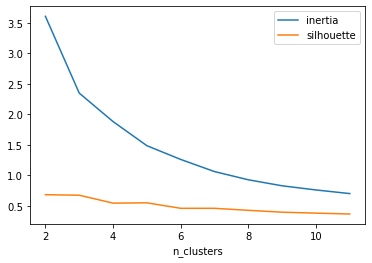

In [7]:
# Oputput inertia plot
plot = pd.DataFrame(cluster_summary).plot(
    x='n_clusters', y=['inertia', 'silhouette'])



<br><br>

## Produce clusters


_N_ based on interia plot above

In [25]:
n = 20
kmeans = KMeans(
    n_clusters=n,
    random_state=0,
)
kmeans = kmeans.fit(X)
# labels = pd.DataFrame(kmeans.labels_, columns='labels')
labels = pd.DataFrame(kmeans.labels_, columns=['labels'])
data.df = data.df.join(labels, lsuffix='drop')
data.df = data.df[[h for h in list(data.df) if 'drop' not in h]]
data.df.sample(5)


,ticker_time,ticker_time_sec,ticker,ticker_interval,volume_base,volume,open,high,low,close,open_high,open_low,open_close,ROR_n5,ROR_n10,ROR_n15,ROR_n20,labels
25291,2020-09-29 23:00:00+00:00,1601420400,BTC-USD,hour,1833.30,19855930.80,10769.17,10863.02,10768.82,10841.29,0.00868,-0.00003,0.00667,0.010210,0.007622,0.009823,0.013876,13
11953,2019-03-24 05:00:00+00:00,1553403600,BTC-USD,hour,372.92,1490613.10,3997.94,3998.60,3991.75,3991.94,0.00017,-0.00155,-0.00150,-0.002609,-0.001097,-0.000994,-0.005394,7
3311,2018-03-29 03:00:00+00:00,1522292400,BTC-USD,hour,2885.99,22796076.03,7921.31,7921.83,7859.56,7890.71,0.00007,-0.00783,-0.00387,-0.008798,-0.007068,-0.018931,-0.000300,6
22819,2020-06-18 23:00:00+00:00,1592521200,BTC-USD,hour,688.21,6461832.48,9370.35,9406.71,9363.52,9380.67,0.00387,-0.00073,0.00110,-0.001029,-0.002230,-0.005236,-0.004383,4
22667,2020-06-12 15:00:00+00:00,1591974000,BTC-USD,hour,5528.56,51998763.38,9417.63,9443.30,9379.26,9416.38,0.00272,-0.00408,-0.00013,-0.004901,0.004286,0.011826,0.014747,7


In [26]:
# Output features and labels
data.to_db(
    project_id='algom-trading',
    destination_table='clustering.1candle_cluster_n{}'.format(n),
    if_exists='replace'
)

1it [00:12, 12.24s/it]
